In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) #no scientific notation
import tensorflow as tf
from tensorflow import keras

# Naive Bayes Classifier

In [ ]:
class MultinomialNaiveBayes:
    
    def __init__(self):
        return


    def fit(self, x, y):
      C = np.max(y) + 1
      self.C = C
      Nc = np.zeros(C) # number of instances in class c
      dico_conditionals_per_class = dict.fromkeys((range(C)))

      unique_words_all, word_count_all = np.unique(x.indices, return_counts=True )   #get number of appearances of word w in total
      vocabulary_size = unique_words_all.shape[0]   #total number of distinct words in all classes
      self.vocabulary_size = vocabulary_size

      for c in range(C):
        x_c = x[y == c]                           #slice all the elements from class c
        Nc[c] = x_c.shape[0]                      #get number of elements of class c
        unique_keys, counts = np.unique(x_c.indices, return_counts=True )   #get number of appearances of word w per class c
        nb_words_per_class = counts.sum() #sum all occurences in this class (not distinct)
        smoothed_counts = counts + np.ones(counts.shape)   #add smoothing +1
        conditionals = np.zeros(unique_keys.shape)
        total_smoothed_count = nb_words_per_class + vocabulary_size   #count(c)+|V|
        conditionals = smoothed_counts / total_smoothed_count   #conditional probabilities : (count(w,c)+1) / (count(c)+|V|)
        keys_conditionals = np.column_stack((unique_keys,conditionals))    # matrix[words, conditional_probs]
        dico_conditionals_per_class[c]  =  keys_conditionals

      self.dico_conditionals_per_class =  dico_conditionals_per_class

      total_nb_docs = Nc.sum()
      priors = Nc/total_nb_docs      #class probs
      self.priors = priors
      return self

    def predict(self,xt):
      Nt, D = xt.shape
      all_posteriors = np.zeros((Nt,self.C))    #hold log_posterior per class
      for d in range(Nt): # Iterating through all the dataset
        doc = xt[d]
        for c in range(self.C): 
          #get conditional for each word given class c
          c_likelihoods = self.dico_conditionals_per_class[c]   #2D array [[word_id, prob],...]
          wlog_likelihoods = 0
          for i in range(doc.indices.shape[0]):  #each word in doc
            index = np.where(c_likelihoods[:, 0] == doc.indices[i])[0]
            if index.size==0 :
              word_likelihood = 1/self.vocabulary_size    #if word id not found : use 1/V
            else :
              word_likelihood = c_likelihoods[index][0][1]
            log_likelihood = np.log2(word_likelihood) * doc.data[i]
            wlog_likelihoods += log_likelihood
          log_prior = np.log2(self.priors[c])
          log_posterior = log_prior + wlog_likelihoods    #posterior = prior * conditional for each word
          all_posteriors[d][c] = log_posterior   #store 
      
      predicted = np.argmax(all_posteriors, axis=1)
      return predicted  

    def evaluate_acc(self, y, yhat):
      accuracy = np.sum(y == yhat)/y.shape[0]
      return accuracy

In [ ]:
def cross_validate_split(n, n_folds=5, percent=False):
    #get the number of data samples in each split
    n_val = n // n_folds
    n_val = int(n_val)
    inds = np.random.permutation(n)
    inds = []
    if percent:
        n_folds = 5
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

In [ ]:
def kfoldCV(model, data, label, cv):
    err_valid = []
    for f, (tr, val) in enumerate(cv):
      model.fit(data[tr],label[tr])
      yhat = model.predict(data[val])
      acc = model.evaluate_acc(label[val],yhat)
      print('Fold ', f, '========> Acc:',acc)

      err_valid.append(acc)
    return np.array(err_valid).mean()

In [ ]:
def partialTrain(model, data, label, percent):
    err_valid = []
    for f, (tr, val) in enumerate(cross_validate_split(data.shape[0], (1-percent)**-1, True)):
      model.fit(data[tr],label[tr])
      yhat = model.predict(data[val])
      acc = model.evaluate_acc(label[val],yhat)
      print('Fold ', f, '========> Acc:',acc)

      err_valid.append(acc)
      break
    return np.array(err_valid).mean()

#IMDB Dataset


In [ ]:
(ximdb_train, yreviews_train), (ximdb_test, yreviews_test) = tf.keras.datasets.imdb.load_data(path='imdb.npz') # num_words , skip_top
ximdb_train_data = np.append(ximdb_train, ximdb_test)
ximdb_label_data = np.append(yreviews_train, yreviews_test)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
# Turn numerical data in text data
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+3) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}

xreviews_train = []
for i in range(ximdb_label_data.shape[0]):
  xreviews_train.append(' '.join(id_to_word[id] for id in ximdb_train_data[i] ))



In [ ]:
imdb_vectorizer =  CountVectorizer(stop_words='english', max_features=100)
xreviews_train = imdb_vectorizer.fit_transform(xreviews_train)


#### Note: This will take some time to run, because of the size of the feature vector. The progress will appear at each fold and finally return the average towards the end.

In [ ]:
from scipy.sparse import coo_matrix, vstack

num_instances = xreviews_train.shape[0]
num_folds=5
model = MultinomialNaiveBayes()
avg = kfoldCV(model, xreviews_train, ximdb_label_data, cross_validate_split(num_instances, num_folds))
print('Average:', avg)

Fold  0 ========> Acc: 0.7154
Average: 0.7154
Fold  0 ========> Acc: 0.7174490699734278
Average: 0.7174490699734278
Fold  0 ========> Acc: 0.7178905963532117
Average: 0.7178905963532117
Fold  0 ========> Acc: 0.71644
Average: 0.71644
Fold  0 ========> Acc: 0.71325
Average: 0.71325
Fold  0 ========> Acc: 0.7170666666666666
Average: 0.7170666666666666
Fold  0 ========> Acc: 0.7153715371537154
Average: 0.7153715371537154


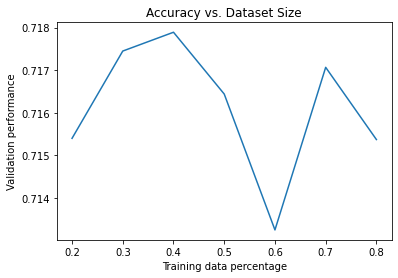

In [ ]:
from scipy.sparse import coo_matrix, vstack
import matplotlib.pyplot as plt

res = []

for percentage in [0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
      model = MultinomialNaiveBayes()
      avg = partialTrain(model, xreviews_train, ximdb_label_data, percentage)
      print('Average:', avg)
      res.append(avg)
plt.xlabel('Training data percentage')
plt.ylabel('Validation performance')
plt.title('Accuracy vs. Dataset Size')
plt.plot([0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8],res)

# Newsgroup 20 Dataset

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='all',remove=('headers','footers','quotes'))

xnews_train = newsgroups_train.data
ynews_train = newsgroups_train.target

In [ ]:
vectorizer = CountVectorizer(stop_words='english', max_features=100)
xnews_train = vectorizer.fit_transform(xnews_train)


#### Note: This will take some time to run, because of the size of the feature vector. The progress will appear at each fold and finally return the average towards the end.

In [ ]:
from scipy.sparse import coo_matrix, vstack

num_instances = xnews_train.shape[0]
num_folds=5
model = MultinomialNaiveBayes()
avg = kfoldCV(model, xnews_train, ynews_train, cross_validate_split(num_instances, num_folds))
print('Average:', avg)

Fold  0 ========> Acc: 0.2434332714247811
Average: 0.2434332714247811
Fold  0 ========> Acc: 0.25742874469375376
Average: 0.25742874469375376
Fold  0 ========> Acc: 0.26638365614221277
Average: 0.26638365614221277
Fold  0 ========> Acc: 0.2682797410591107
Average: 0.2682797410591107
Fold  0 ========> Acc: 0.26452639957548424
Average: 0.26452639957548424
Fold  0 ========> Acc: 0.2715372368653812
Average: 0.2715372368653812
Fold  0 ========> Acc: 0.2695675245423189
Average: 0.2695675245423189


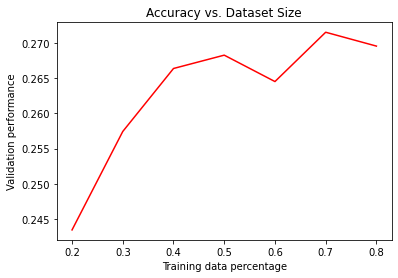

In [ ]:
from scipy.sparse import coo_matrix, vstack
import matplotlib.pyplot as plt

res = []

for percentage in [0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
      model = MultinomialNaiveBayes()
      avg = partialTrain(model, xnews_train, ynews_train, percentage)
      print('Average:', avg)
      res.append(avg)
plt.xlabel('Training data percentage')
plt.ylabel('Validation performance')
plt.title('Accuracy vs. Dataset Size')
plt.plot([0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8],res,color='red')

# Logistic Regression (Benchmark)




### IMDB Logistic Regression (Benchmark)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier 
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
eta0 = [1, 10, 100] 
param_distributions = dict(alpha=alpha, learning_rate=learning_rate, eta0=eta0) 

In [ ]:
sgd = SGDClassifier(loss="log", penalty=None) 
random = RandomizedSearchCV(estimator=sgd, param_distributions=param_distributions, cv=5) 
random_result = random.fit(xreviews_train, ximdb_label_data) 
print('Best Score: ', random_result.best_score_) 
print('Best Params: ', random_result.best_params_) 

Best Score:  0.8657999999999999
Best Params:  {'learning_rate': 'adaptive', 'eta0': 100, 'alpha': 0.001}


### Newsgroup Logistic Regression (Benchmark)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier 
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
eta0 = [1, 10, 100] 
param_distributions = dict(alpha=alpha, learning_rate=learning_rate, eta0=eta0) 

In [ ]:
sgd = SGDClassifier(loss="log", penalty=None) 
random = RandomizedSearchCV(estimator=sgd, param_distributions=param_distributions, cv=5) 
random_result = random.fit(xnews_train, ynews_train) 
print('Best Score: ', random_result.best_score_) 
print('Best Params: ', random_result.best_params_) 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Best Score:  0.659556510497124
Best Params:  {'learning_rate': 'constant', 'eta0': 10, 'alpha': 0.1}
